# Data Analysis Notebok

This notebook is used to analyze the data generated during our numerical expeirments and to make plots.

In [1]:
# imports 
import tqdm
import os
import pickle
import numpy as np
import torch
import rubiks.clifford as cl

In [2]:
# plotting imports and settings
import matplotlib
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import matplotlib.pyplot as plt
from matplotlib.cm import get_cmap
from cycler import cycler

plt.rcParams["xtick.direction"] = "in"
plt.rcParams["ytick.direction"] = "in"
plt.rcParams["xtick.major.size"] = 5.0
plt.rcParams["xtick.minor.size"] = 3.0
plt.rcParams["ytick.major.size"] = 5.0
plt.rcParams["ytick.minor.size"] = 3.0
plt.rc("font", family="serif", size=16)
# matplotlib.rc('text', usetex=True)
#matplotlib.rc("legend", fontsize=14)
plt.rcParams["ytick.minor.size"] = 3.0
matplotlib.rcParams.update(
    {"axes.grid": True, "grid.alpha": 0.75, "grid.linewidth": 0.5}
)

name = "tab20"
cmap = get_cmap(name)  # type: matplotlib.colors.ListedColormap
colors_tab = cmap.colors  # type: list

matplotlib.rcParams["axes.prop_cycle"] = cycler(
    #color=["#E24A33", "#348ABD", "#988ED5", "#777777", "#FBC15E", "#8EBA42", "#FFB5B8"]
    #color=['#4165c0', '#e770a2', '#5ac3be', '#696969', '#f79a1e', '#ba7dcd'] #retro
    #color=["#0d49fb", "#e6091c", "#26eb47", "#8936df", "#fec32d", "#25d7fd"] #high-vis
    #color=['#0C5DA5', '#00B945', '#FF9500', '#FF2C00', '#845B97', '#474747', '#9e9e9e'] #std-colors
    color=colors_tab,
)

colors = plt.rcParams["axes.prop_cycle"].by_key()["color"]

/tmp/ipykernel_1784315/4040430819.py:23: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = get_cmap(name)  # type: matplotlib.colors.ListedColormap


In [3]:
# Set RNG
rng = np.random.default_rng(1337)

In [4]:
# paths and data selection
max_num_qubits = 12 # maximum number of qubits to consider
num_qubit_list= [n for n in range(3, max_num_qubits + 1)]

eval_max_iter = 200
eval_num_trials = 5000
beam_width = 3

scaling_list = ['linear', 'log-linear']
#scaling_list = ['linear'] # list of scaling types to consider

methods = ['lgf', 'beam-3']
eval_dir = "eval_beamsearch"

# make a figure directory
figure_dir = "figures_beamsearch"
if not os.path.exists(figure_dir):
    os.makedirs(figure_dir)

## Preliminaries

How does the size of the Clifford group scale with circuit width $n$ (qubits)?

In [5]:
# inspect how the Clifford group size scales with n
for n in range(2, 13):
    print(f"n = {n}")
    print(f"  Move set size = {int(cl.size_movet_set(n))}")
    print(f"  Clifford group size = {np.exp(cl.clifford_log_dim(n)):.2e}")

n = 2
  Move set size = 15
  Clifford group size = 1.15e+04
n = 3
  Move set size = 27
  Clifford group size = 9.29e+07
n = 4
  Move set size = 42
  Clifford group size = 1.21e+13
n = 5
  Move set size = 60
  Clifford group size = 2.54e+19
n = 6
  Move set size = 81
  Clifford group size = 8.52e+26
n = 7
  Move set size = 105
  Clifford group size = 4.58e+35
n = 8
  Move set size = 132
  Clifford group size = 3.93e+45
n = 9
  Move set size = 162
  Clifford group size = 5.40e+56
n = 10
  Move set size = 195
  Clifford group size = 1.19e+69
n = 11
  Move set size = 231
  Clifford group size = 4.18e+82
n = 12
  Move set size = 270
  Clifford group size = 2.35e+97


In [6]:
# build a dictionary of the high parameter as a function of n for various scaling types
num_qubit_scaling_fn = {
    'log': lambda n : int(20 * np.log(n)/np.log(2)),
    'linear': lambda n : int(20 * n/2),    
    'log-linear': lambda n : int(10 * n * np.log(n)/np.log(2))
}

# print out
for n in range(2, 15):
    print(
        f"num_qubits={n}, Lmax (log) = {num_qubit_scaling_fn['log'](n)}" 
        + f"   Lmax (linear) = {num_qubit_scaling_fn['linear'](n)},   Lmax (log-inear) = {num_qubit_scaling_fn['log-linear'](n)}"
        )

num_qubits=2, Lmax (log) = 20   Lmax (linear) = 20,   Lmax (log-inear) = 20
num_qubits=3, Lmax (log) = 31   Lmax (linear) = 30,   Lmax (log-inear) = 47
num_qubits=4, Lmax (log) = 40   Lmax (linear) = 40,   Lmax (log-inear) = 80
num_qubits=5, Lmax (log) = 46   Lmax (linear) = 50,   Lmax (log-inear) = 116
num_qubits=6, Lmax (log) = 51   Lmax (linear) = 60,   Lmax (log-inear) = 155
num_qubits=7, Lmax (log) = 56   Lmax (linear) = 70,   Lmax (log-inear) = 196
num_qubits=8, Lmax (log) = 60   Lmax (linear) = 80,   Lmax (log-inear) = 240
num_qubits=9, Lmax (log) = 63   Lmax (linear) = 90,   Lmax (log-inear) = 285
num_qubits=10, Lmax (log) = 66   Lmax (linear) = 100,   Lmax (log-inear) = 332
num_qubits=11, Lmax (log) = 69   Lmax (linear) = 110,   Lmax (log-inear) = 380
num_qubits=12, Lmax (log) = 71   Lmax (linear) = 120,   Lmax (log-inear) = 430
num_qubits=13, Lmax (log) = 74   Lmax (linear) = 130,   Lmax (log-inear) = 481
num_qubits=14, Lmax (log) = 76   Lmax (linear) = 140,   Lmax (log-inear

In [7]:
## build a dictionary of data directories for the different values of n and scaling
drop_phase_bits = True
scaling = 'log-linear'
data_dirs = {}
for scaling in ['linear', 'log-linear']:
    if drop_phase_bits:
        data_dirs[scaling] = {n : f'data_n_{n}_drop_phase_bits_scaling_{scaling}' for n in num_qubit_list}
    else:
        data_dirs[scaling] = {n : f'data_n_{n}_high{fn(n)}' for n in num_qubit_list}

print(data_dirs)

{'linear': {3: 'data_n_3_drop_phase_bits_scaling_linear', 4: 'data_n_4_drop_phase_bits_scaling_linear', 5: 'data_n_5_drop_phase_bits_scaling_linear', 6: 'data_n_6_drop_phase_bits_scaling_linear', 7: 'data_n_7_drop_phase_bits_scaling_linear', 8: 'data_n_8_drop_phase_bits_scaling_linear', 9: 'data_n_9_drop_phase_bits_scaling_linear', 10: 'data_n_10_drop_phase_bits_scaling_linear', 11: 'data_n_11_drop_phase_bits_scaling_linear', 12: 'data_n_12_drop_phase_bits_scaling_linear'}, 'log-linear': {3: 'data_n_3_drop_phase_bits_scaling_log-linear', 4: 'data_n_4_drop_phase_bits_scaling_log-linear', 5: 'data_n_5_drop_phase_bits_scaling_log-linear', 6: 'data_n_6_drop_phase_bits_scaling_log-linear', 7: 'data_n_7_drop_phase_bits_scaling_log-linear', 8: 'data_n_8_drop_phase_bits_scaling_log-linear', 9: 'data_n_9_drop_phase_bits_scaling_log-linear', 10: 'data_n_10_drop_phase_bits_scaling_log-linear', 11: 'data_n_11_drop_phase_bits_scaling_log-linear', 12: 'data_n_12_drop_phase_bits_scaling_log-linear'}}

## Data Analysis

Analyze the data generated by running `clifford.py` for various circuit widths.

Examine the loss, both throughout training and the final value.

/tmp/ipykernel_1784315/2333525299.py:3: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = get_cmap(name)  # type: matplotlib.colors.ListedColormap


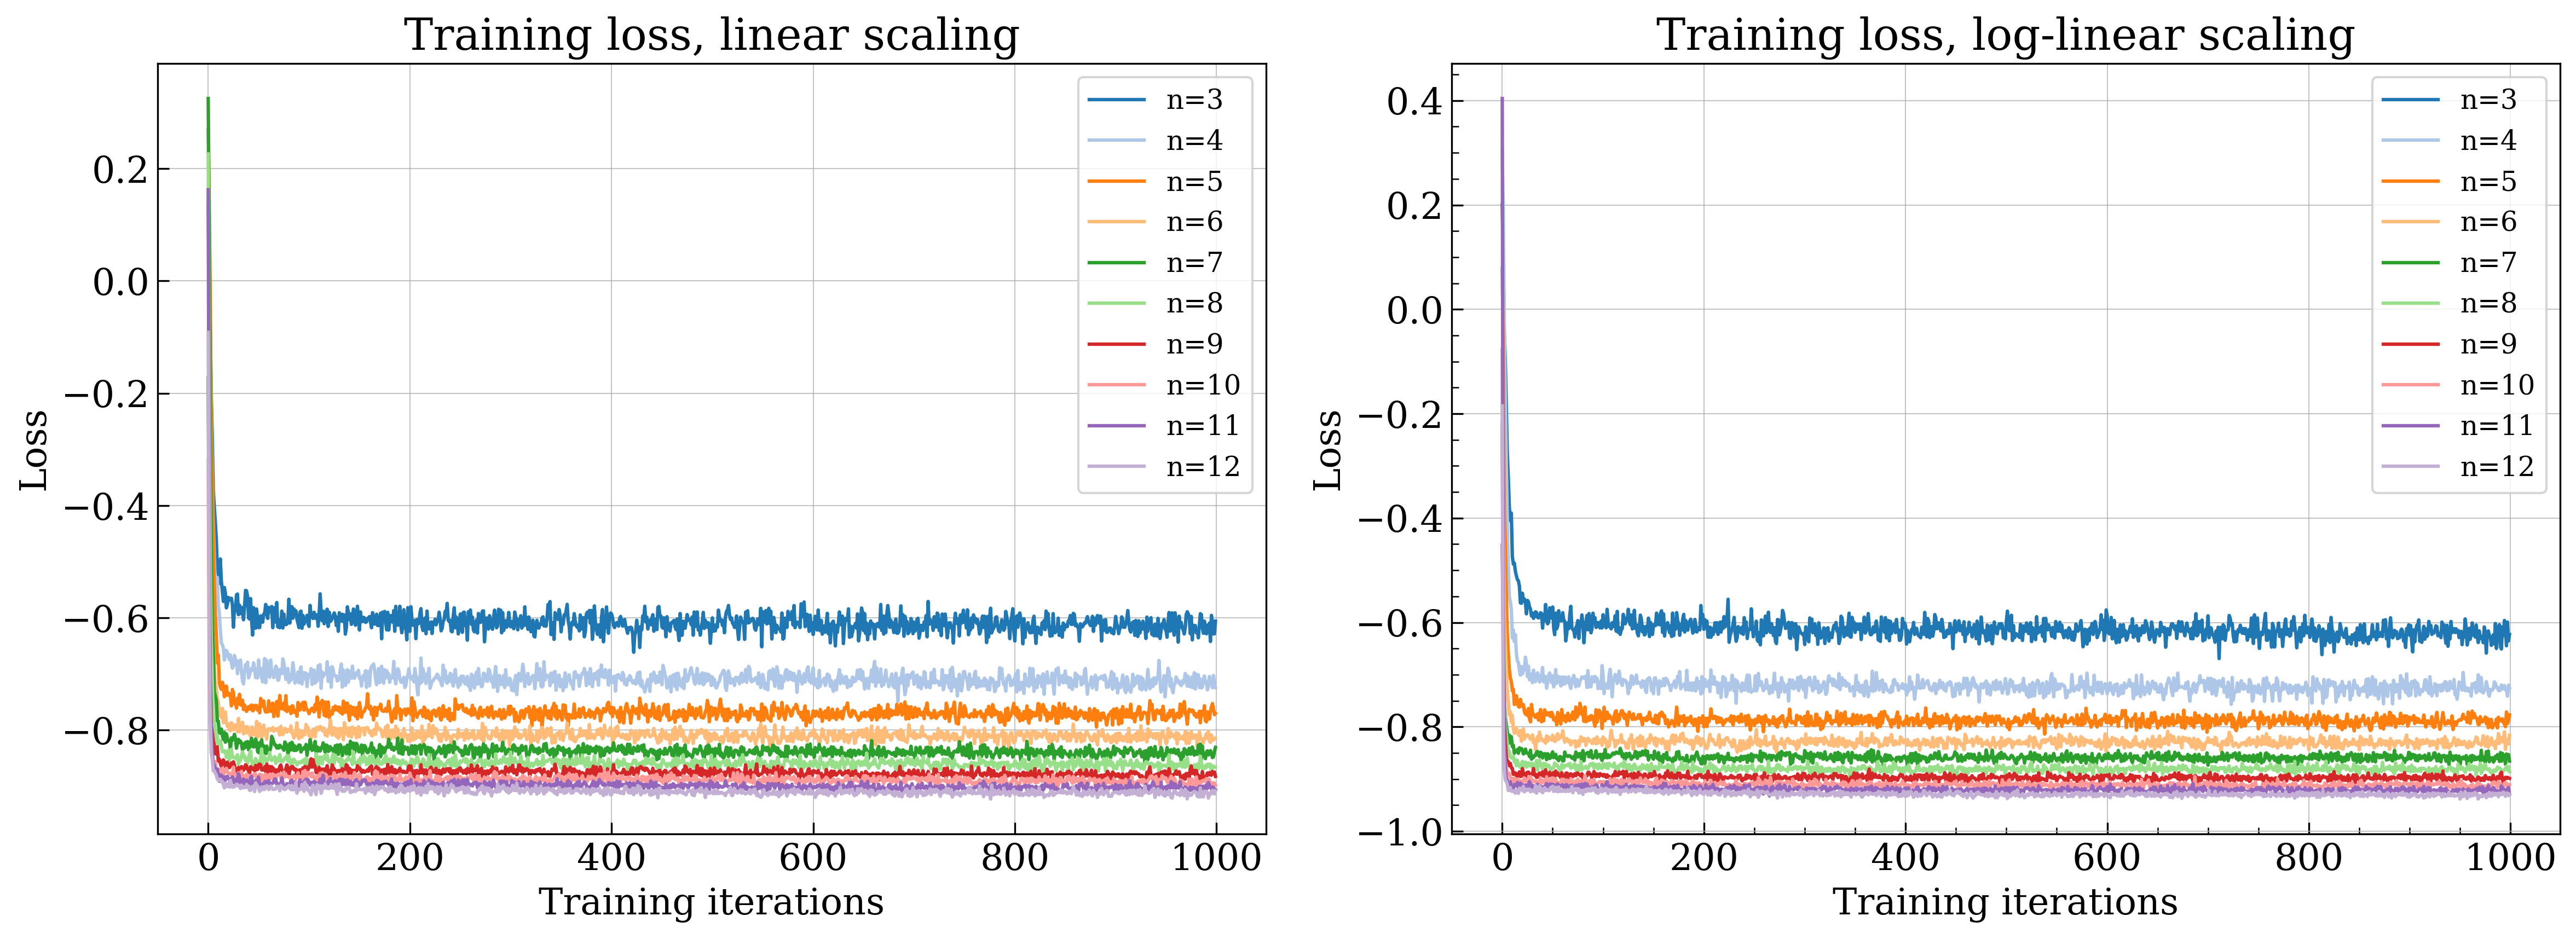

In [8]:
# use a different color scheme to plot a large number of curves
name = "tab20"
cmap = get_cmap(name)  # type: matplotlib.colors.ListedColormap
colors_tab = cmap.colors  # type: list

fig, ax = plt.subplots(1, 2, figsize=(2 * 8, 6), dpi=300)
[ax[i].set_prop_cycle(color=colors_tab) for i in range(len(ax))]

for ax_idx, scaling in enumerate(scaling_list):
    final_loss_list = []
    for num_qubits in num_qubit_list:
        loss_history = np.load("data/" + data_dirs[scaling][num_qubits] + "/loss_history.npy")
        ax[ax_idx].plot(np.asarray(loss_history), label=f"n={num_qubits}")
        final_loss_list.append(np.mean(loss_history[-10:]))

    ax[ax_idx].set_xlabel("Training iterations")
    ax[ax_idx].set_ylabel("Loss")
    ax[ax_idx].set_title(f"Training loss, {scaling} scaling")
    ax[ax_idx].legend(fontsize=12)  # bbox_to_anchor=(-0.2, 1))
    #ax[ax_idx].set_xscale('log')

plt.minorticks_on()
plt.tight_layout()
#plt.savefig(f"{figure_dir}/training_history.png")
plt.show()

Make a plot of the final loss

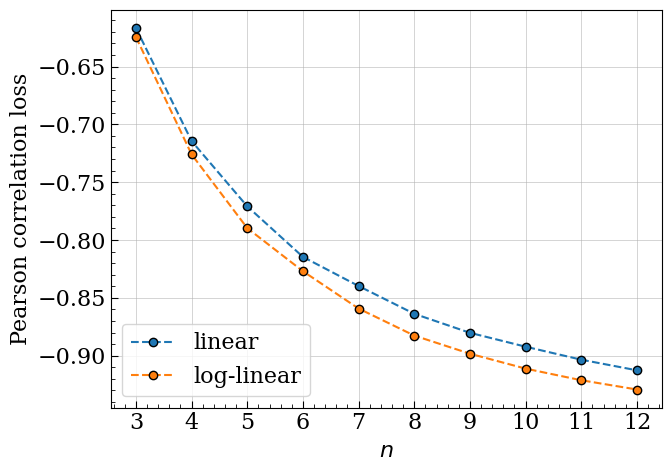

In [9]:
fig, ax = plt.subplots( figsize=(7, 5))

for idx, scaling in enumerate(['linear', 'log-linear']):

    final_loss_list = []
    for num_qubits in num_qubit_list:
        loss_history = np.load("data/" + data_dirs[scaling][num_qubits] + "/loss_history.npy")
        final_loss_list.append(np.mean(loss_history[-20:]))
    final_loss_list = np.asarray(final_loss_list)

    ax.plot(num_qubit_list, final_loss_list, "--o", markeredgecolor="k", label=scaling, color=colors[2*idx])

ax.set_xlabel(r"$n$")
ax.set_ylabel("Pearson correlation loss")
ax.legend(loc='lower left')
ax.set_xticks(np.arange(3, len(num_qubit_list) + 3))

plt.minorticks_on()
plt.tight_layout()
plt.savefig(f"{figure_dir}/final_training_loss.png")

plt.show()

Do an exponential fit
- slope is very small, and the number of decades the data ranges over is quite small also, so this is probably not worthwhile.

In [10]:
from sklearn.linear_model import LinearRegression

X = np.asarray(num_qubit_list)[:, None]
y = 1 + final_loss_list
reg = LinearRegression().fit(X, y)
reg.coef_, reg.intercept_

(array([-0.03001691]), 0.3882349143786864)

Make a plot of the cumulative fraction of instances solved 

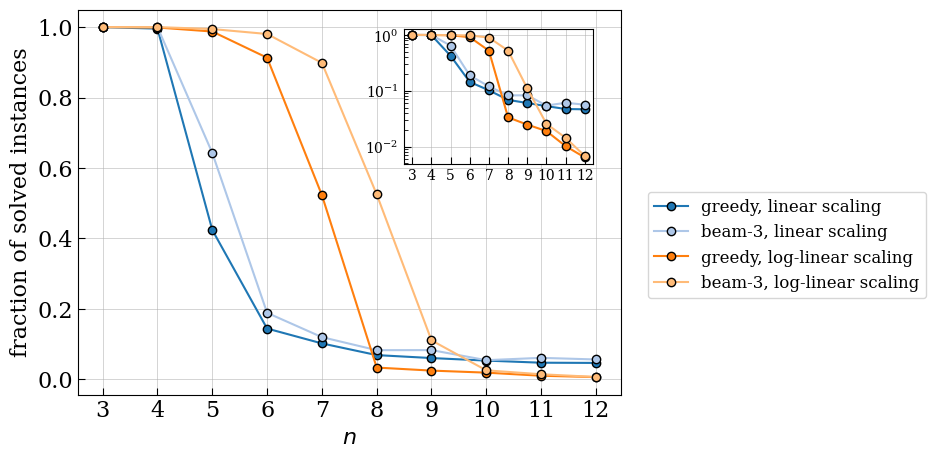

In [11]:
fig, ax = plt.subplots(figsize=(7, 5))
#axinset = inset_axes(ax, width=0.6*7/5, height=0.6)
axinset = ax.inset_axes(bounds=[0.6, 0.6, 0.35, 0.35])
#axinset.tick_params(axis='both', which='both', labelsize=10)

for scaling in scaling_list:

    fraction_of_solved_instances_hillclimbing = []
    for i, num_qubits in enumerate(num_qubit_list):
        with open(f"data/" + data_dirs[scaling][num_qubits] + f"/eval_beamsearch/steps_until_success_eval_max_iter_{eval_max_iter}_eval_num_trials_{eval_num_trials}_sampling_method_random_walk.pkl", "rb") as f:
            steps_until_success = pickle.load(f)

        fraction_of_solved_instances_hillclimbing.append(
            len([x for x in steps_until_success["lgf"]["weighted_steps"] if x is not None])
            / len(steps_until_success["lgf"]["weighted_steps"])
        )

    ax.plot(num_qubit_list, fraction_of_solved_instances_hillclimbing, "-o", markeredgecolor="k", label=f"greedy, {scaling} scaling")
    axinset.plot(num_qubit_list, fraction_of_solved_instances_hillclimbing, "-o", markeredgecolor="k", label=f"greedy, {scaling} scaling")

    fraction_of_solved_instances_beam = []
    for i, num_qubits in enumerate(num_qubit_list):
        with open(f"data/" + data_dirs[scaling][num_qubits] + f"/eval_beamsearch/steps_until_success_eval_max_iter_{eval_max_iter}_eval_num_trials_{eval_num_trials}_sampling_method_random_walk.pkl", "rb") as f:
            steps_until_success = pickle.load(f)

        fraction_of_solved_instances_beam.append(
            len([x for x in steps_until_success[f"beam-{beam_width}"]["weighted_steps"] if x is not None])
            / len(steps_until_success[f"beam-{beam_width}"]["weighted_steps"])
        )

    ax.plot(num_qubit_list, fraction_of_solved_instances_beam, "-o", markeredgecolor="k", label=f"beam-{beam_width}, {scaling} scaling")
    axinset.plot(num_qubit_list, fraction_of_solved_instances_beam, "-o", markeredgecolor="k", label=f"beam-{beam_width}, {scaling} scaling")

ax.legend(loc=(1.05, 0.25), fontsize=12)
ax.set_xlabel(r"$n$")
ax.set_ylabel(r"fraction of solved instances")
ax.set_xticks(np.arange(3, len(num_qubit_list) + 3))

#axinset.set_xlabel(r"$n$", fontsize=10)
#axinset.set_ylabel(r"fraction of solved instances")
axinset.set_yscale('log')
axinset.set_xticks(np.arange(3, len(num_qubit_list) + 3))
axinset.tick_params(axis='both', which='major', labelsize=10)

plt.savefig(f"{figure_dir}/fraction_solved_instances.png")

plt.show()

Now add in the comparison with the built-in Qiskit method.

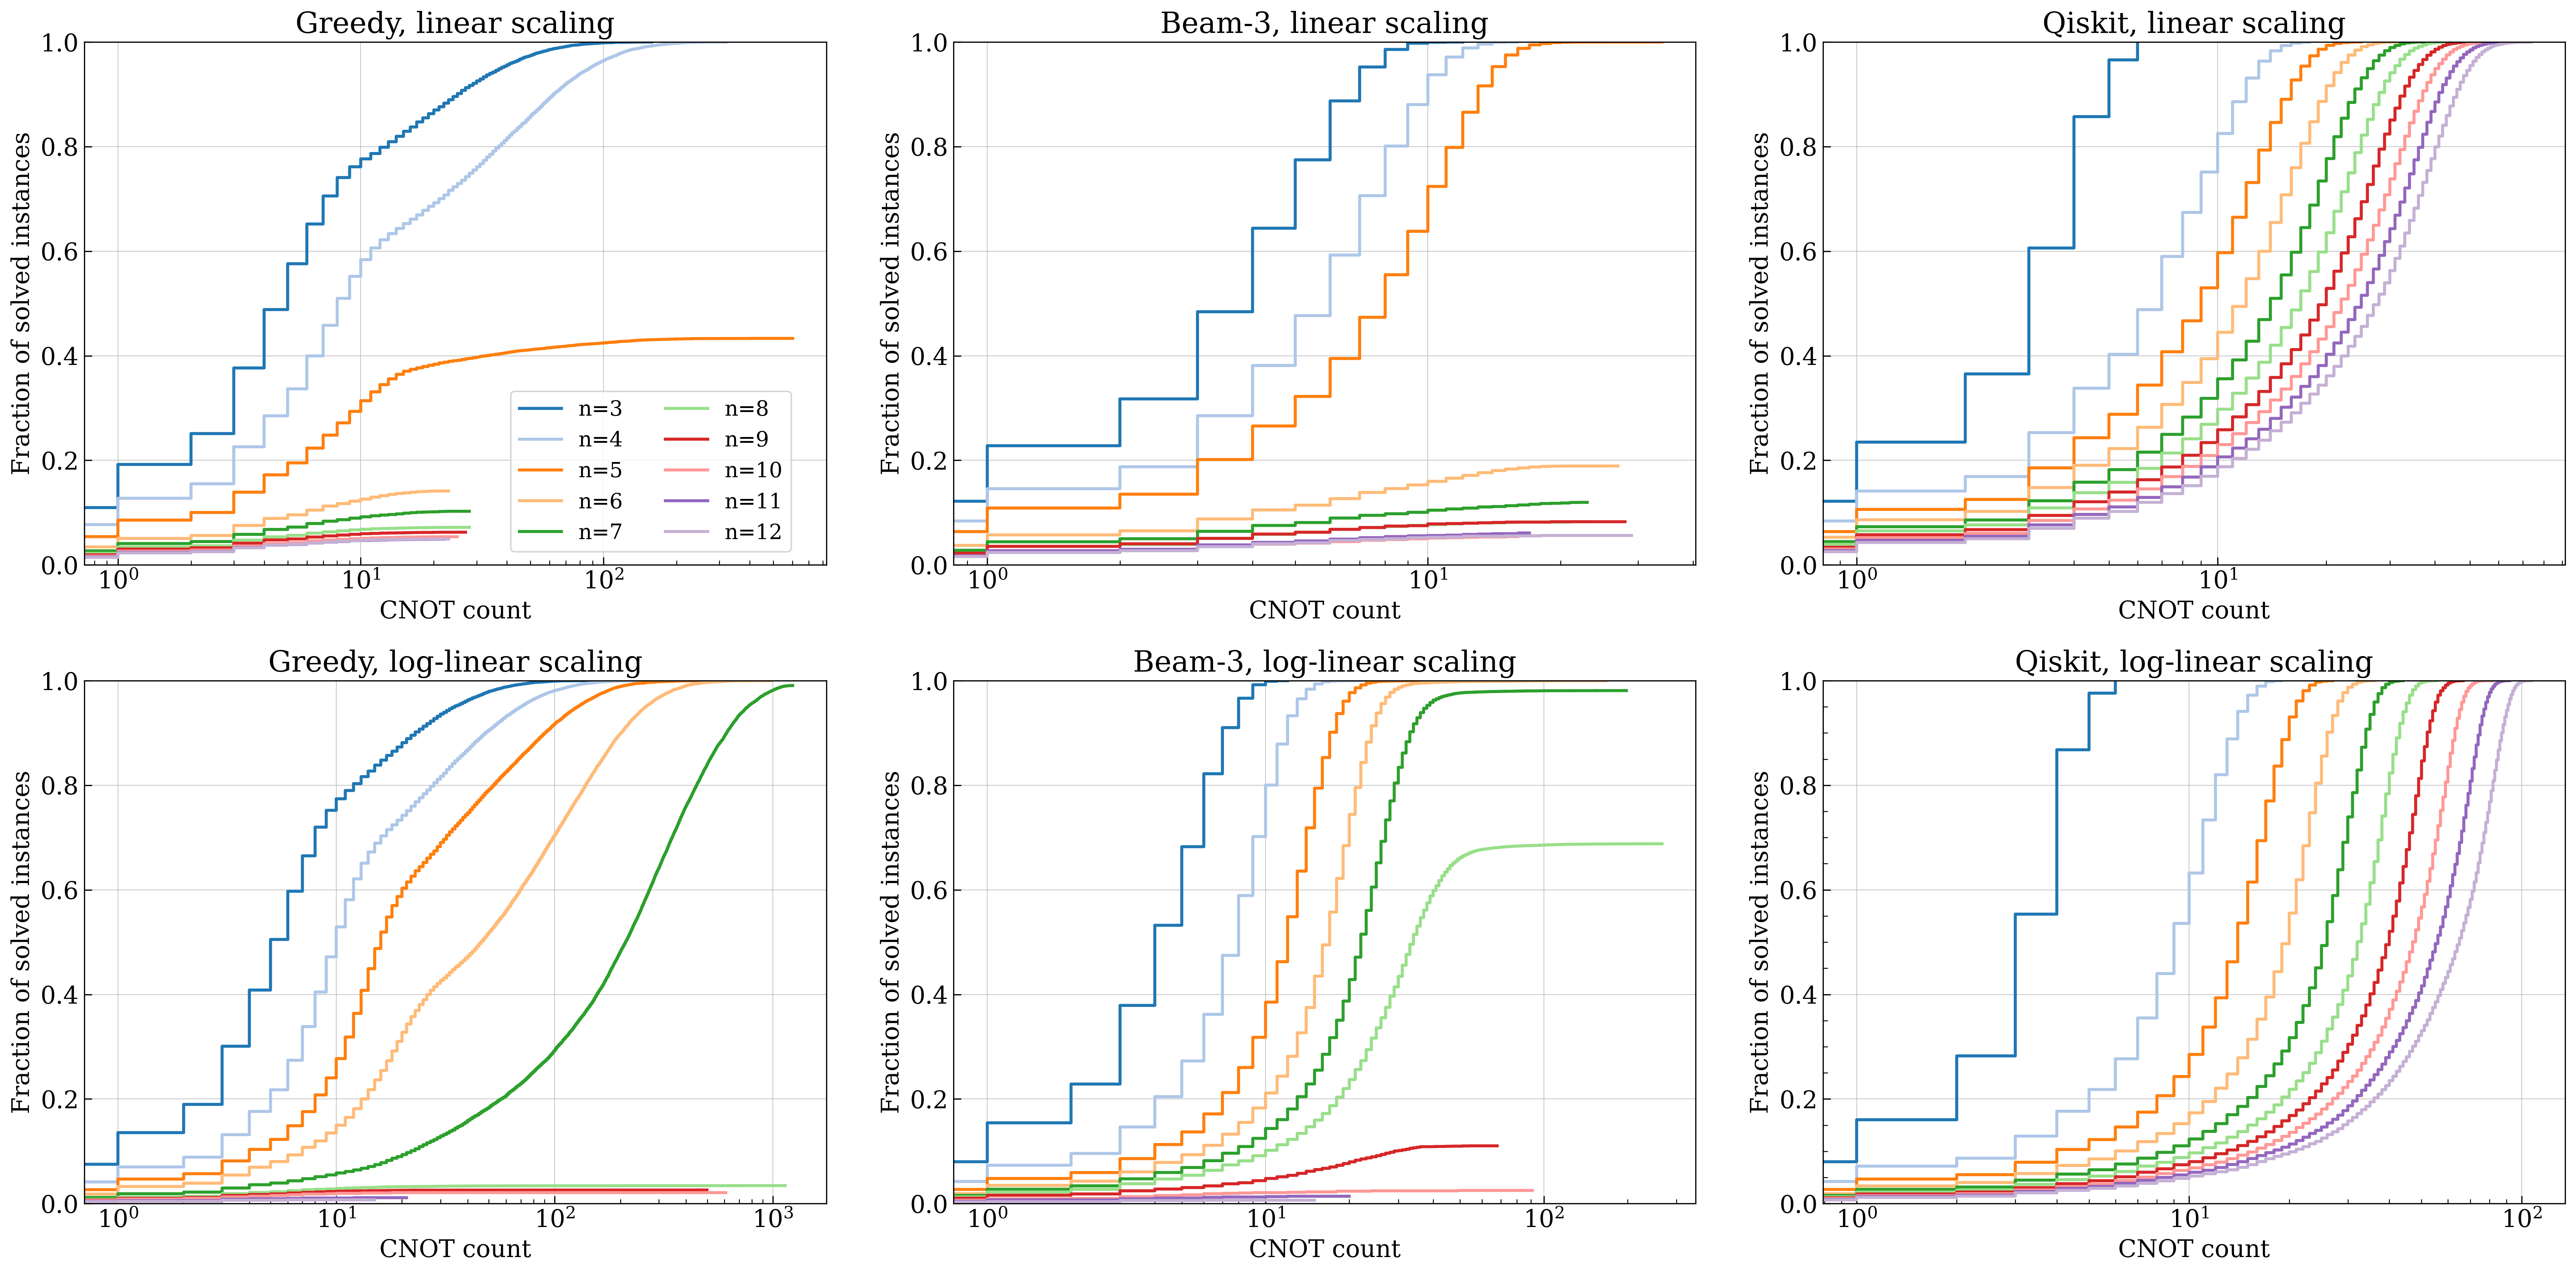

In [12]:
fig, ax = plt.subplots(len(scaling_list), 3, figsize=(3 * 8, len(scaling_list) * 6), dpi=300)
ax = ax.flatten()

for i_scaling, scaling in enumerate(scaling_list):

    metric = 'CNOTs'
    xlabel = 'CNOT count'

    for i, num_qubits in enumerate(num_qubit_list):
        eval_dir = 'eval_beamsearch'

        # use the more intensive evaluation data if available
        if (scaling == 'log-linear' and num_qubits < 9) or (scaling == 'linear' and num_qubits < 7):
            eval_max_iter = 1000
            eval_num_trials = 20000
        else:
            eval_max_iter = 200
            eval_num_trials = 5000

        with open(
            f"data/" + data_dirs[scaling][num_qubits] + f"/{eval_dir}/steps_until_success_eval_max_iter_{eval_max_iter}_eval_num_trials_{eval_num_trials}_sampling_method_random_walk.pkl", "rb"
        ) as f:
            steps_until_success = pickle.load(f)

        cum_steps_utils_success_beam = np.sort(
            [n for n in steps_until_success[f"beam-{beam_width}"][metric] if n is not None]
        )

        ax[3 * i_scaling + 1].step(
            cum_steps_utils_success_beam,
            np.arange(len(cum_steps_utils_success_beam))
            / len(steps_until_success[f"beam-{beam_width}"][metric]),
            label=f"n={num_qubits}",
            linewidth=2,
            alpha=1.0,
            linestyle="-",
            #color=colors[i],
        )

    for i, num_qubits in enumerate(num_qubit_list):
        eval_dir = 'eval'
        eval_max_iter = 1000
        eval_num_trials = 20000
        with open(
            f"data/" + data_dirs[scaling][num_qubits] + f"/{eval_dir}/steps_until_success_eval_max_iter_{eval_max_iter}_eval_num_trials_{eval_num_trials}_sampling_method_random_walk.pkl", "rb"
        ) as f:
            steps_until_success = pickle.load(f)
        cum_steps_utils_success_qiskit = np.sort(
            [n for n in steps_until_success["qiskit"][metric] if n is not None]
        )
        cum_steps_utils_success_lgf = np.sort(
            [n for n in steps_until_success["lgf"][metric] if n is not None]
        )

        ax[3 * i_scaling].step(
            cum_steps_utils_success_lgf,
            np.arange(len(cum_steps_utils_success_lgf))
            / len(steps_until_success["lgf"][metric]),
            label=f"n={num_qubits}",
            linewidth=2,
            alpha=1.0,
            linestyle="-",
            #color=colors[i],
        )

        ax[3 * i_scaling + 2].step(
            cum_steps_utils_success_qiskit,
            np.arange(len(cum_steps_utils_success_qiskit))
            / len(steps_until_success["qiskit"][metric]),
            label=f"n={num_qubits}",
            linewidth=2,
            alpha=1.0,
            linestyle="-",
            #color=colors[i],
        )

    ax[3 * i_scaling].set_xscale("log")
    ax[3 * i_scaling].set_xlabel(xlabel)
    ax[3 * i_scaling].set_ylabel("Fraction of solved instances")
    ax[3 * i_scaling].set_title(f"Greedy, {scaling} scaling")
    #ax[3 * i_scaling].set_xlim([1, max(ax[0].get_xlim()[1], ax[1].get_xlim()[1])])
    ax[3 * i_scaling].set_ylim([0, 1])

    ax[3 * i_scaling + 1].set_xscale("log")
    ax[3 * i_scaling + 1].set_xlabel(xlabel)
    ax[3 * i_scaling + 1].set_ylabel("Fraction of solved instances")
    ax[3 * i_scaling + 1].set_title(f"Beam-{beam_width}, {scaling} scaling")
    #ax[3 * i_scaling].set_xlim([1, max(ax[0].get_xlim()[1], ax[1].get_xlim()[1])])
    ax[3 * i_scaling + 1].set_ylim([0, 1])

    ax[3 * i_scaling + 2].set_xscale("log")
    ax[3 * i_scaling + 2].set_xlabel(xlabel)
    ax[3 * i_scaling + 2].set_ylabel("Fraction of solved instances")
    ax[3 * i_scaling + 2].set_title(f"Qiskit, {scaling} scaling")
    #ax[3 * i_scaling].set_xlim([1, max(ax[0].get_xlim()[1], ax[1].get_xlim()[1])])
    ax[3 * i_scaling + 2].set_ylim([0, 1])

ax[0].legend(loc=(0.575, 0.025), ncol=2, fontsize=14)
plt.minorticks_on()
plt.tight_layout()
plt.savefig(f"{figure_dir}/cumulative_plot.png")
plt.show()

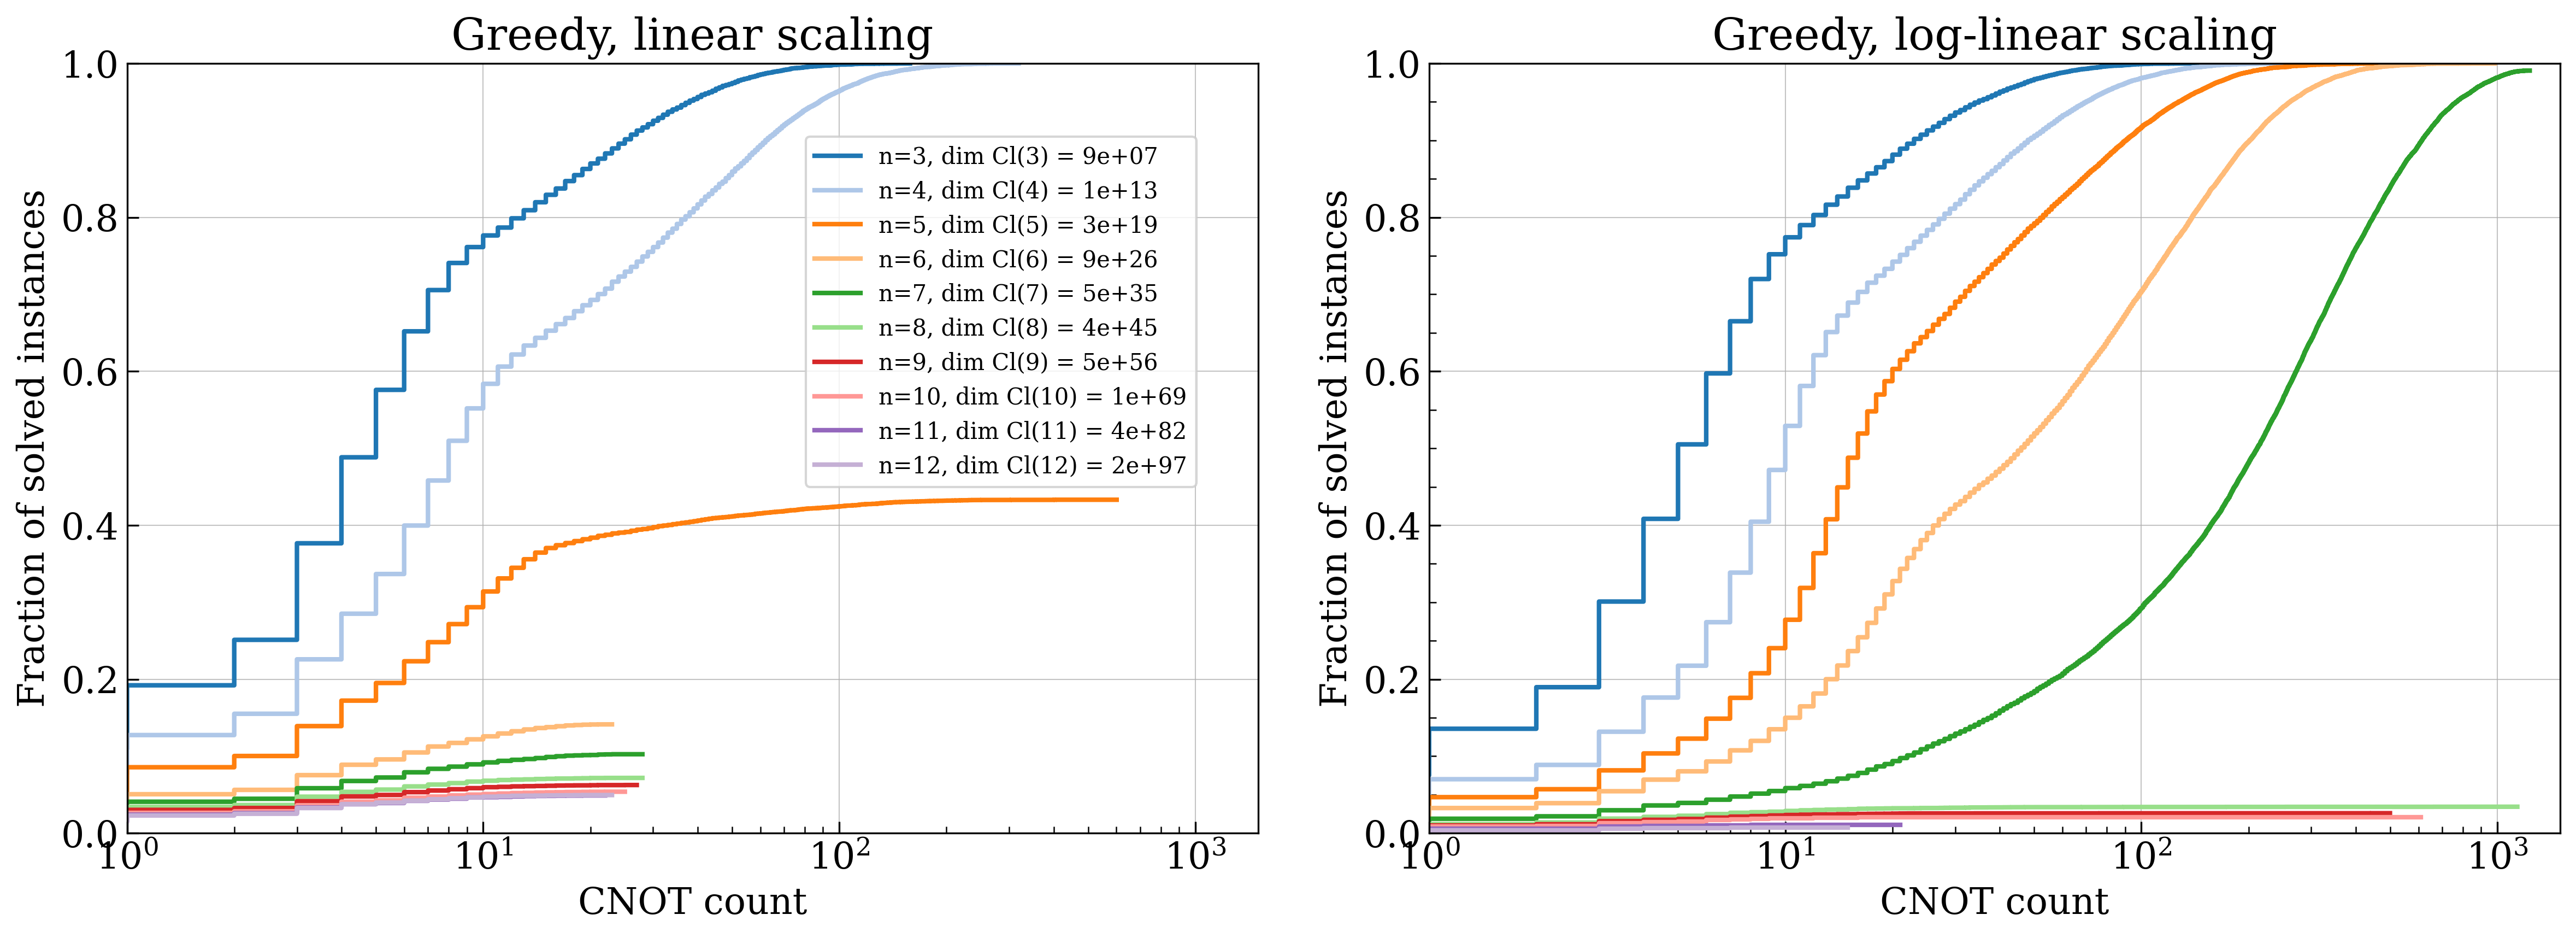

In [13]:
## Greedy only
fig, ax = plt.subplots(1, 2, figsize=(2 * 8, 1 * 6), dpi=300)
ax = ax.flatten()

for i_scaling, scaling in enumerate(scaling_list):

    metric = 'CNOTs'
    xlabel = 'CNOT count'

    for i, num_qubits in enumerate(num_qubit_list):
        eval_dir = 'eval'
        eval_max_iter = 1000
        eval_num_trials = 20000
        with open(
            f"data/" + data_dirs[scaling][num_qubits] + f"/{eval_dir}/steps_until_success_eval_max_iter_{eval_max_iter}_eval_num_trials_{eval_num_trials}_sampling_method_random_walk.pkl", "rb"
        ) as f:
            steps_until_success = pickle.load(f)
        cum_steps_utils_success_qiskit = np.sort(
            [n for n in steps_until_success["qiskit"][metric] if n is not None]
        )
        cum_steps_utils_success_lgf = np.sort(
            [n for n in steps_until_success["lgf"][metric] if n is not None]
        )

        ax[i_scaling].step(
            cum_steps_utils_success_lgf,
            np.arange(len(cum_steps_utils_success_lgf))
            / len(steps_until_success["lgf"][metric]),
            label=f"n={num_qubits}, dim Cl({num_qubits}) = {np.exp(cl.clifford_log_dim(num_qubits)):.0e}",
            linewidth=2,
            alpha=1.0,
            linestyle="-",
            #color=colors[i],
        )


    ax[i_scaling].set_xscale("log")
    ax[i_scaling].set_xlabel(xlabel)
    ax[i_scaling].set_ylabel("Fraction of solved instances")
    ax[i_scaling].set_title(f"Greedy, {scaling} scaling")
    ax[i_scaling].set_ylim([0, 1])
    ax[i_scaling].set_xlim([1, 1500])

ax[0].legend(loc=(0.6, 0.45), ncol=1, fontsize=10)
plt.minorticks_on()
plt.tight_layout()
#plt.savefig(f"{figure_dir}/cumulative_plot.png")
plt.show()

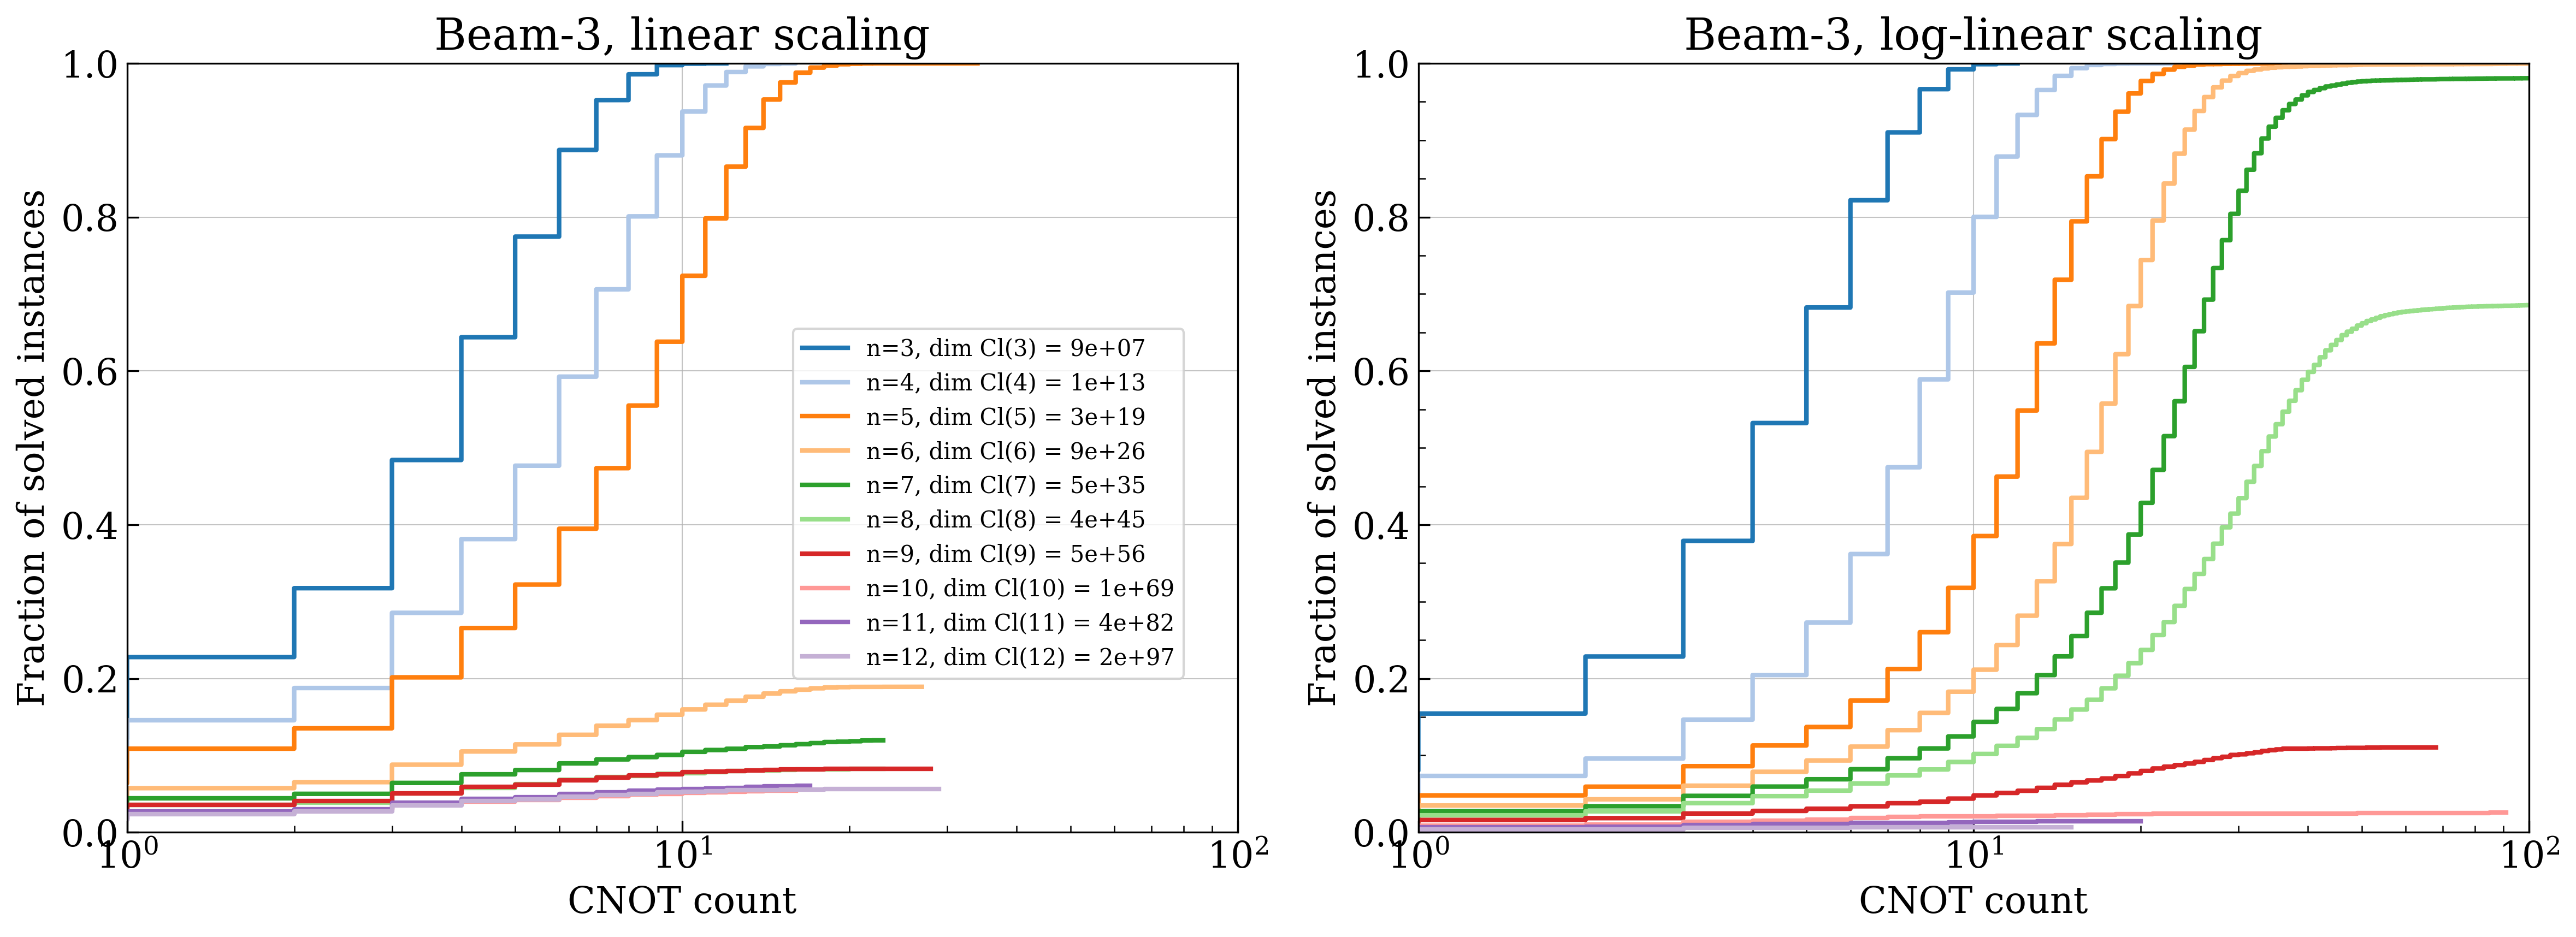

In [14]:
## Beam-search only
fig, ax = plt.subplots(1, 2, figsize=(2 * 8, 1 * 6), dpi=300)
ax = ax.flatten()

for i_scaling, scaling in enumerate(scaling_list):

    metric = 'CNOTs'
    xlabel = 'CNOT count'

    for i, num_qubits in enumerate(num_qubit_list):

        eval_dir = 'eval_beamsearch'

        # use the more intensive evaluation data if available
        if (scaling == 'log-linear' and num_qubits < 9) or (scaling == 'linear' and num_qubits < 7):
            eval_max_iter = 1000
            eval_num_trials = 20000
        else:
            eval_max_iter = 200
            eval_num_trials = 5000

        with open(
            f"data/" + data_dirs[scaling][num_qubits] + f"/{eval_dir}/steps_until_success_eval_max_iter_{eval_max_iter}_eval_num_trials_{eval_num_trials}_sampling_method_random_walk.pkl", "rb"
        ) as f:
            steps_until_success = pickle.load(f)

        cum_steps_utils_success_beam = np.sort(
            [n for n in steps_until_success[f"beam-{beam_width}"][metric] if n is not None]
        )

        ax[i_scaling].step(
            cum_steps_utils_success_beam,
            np.arange(len(cum_steps_utils_success_beam))
            / len(steps_until_success["beam-3"][metric]),
            label=f"n={num_qubits}, dim Cl({num_qubits}) = {np.exp(cl.clifford_log_dim(num_qubits)):.0e}",
            linewidth=2,
            alpha=1.0,
            linestyle="-",
            #color=colors[i],
        )


    ax[i_scaling].set_xscale("log")
    ax[i_scaling].set_xlabel(xlabel)
    ax[i_scaling].set_ylabel("Fraction of solved instances")
    ax[i_scaling].set_title(f"Beam-3, {scaling} scaling")
    ax[i_scaling].set_ylim([0, 1])
    ax[i_scaling].set_xlim([1, 100])

ax[0].legend(loc=(0.6, 0.2), ncol=1, fontsize=10)
plt.minorticks_on()
plt.tight_layout()
#plt.savefig(f"{figure_dir}/cumulative_plot.png")
plt.show()

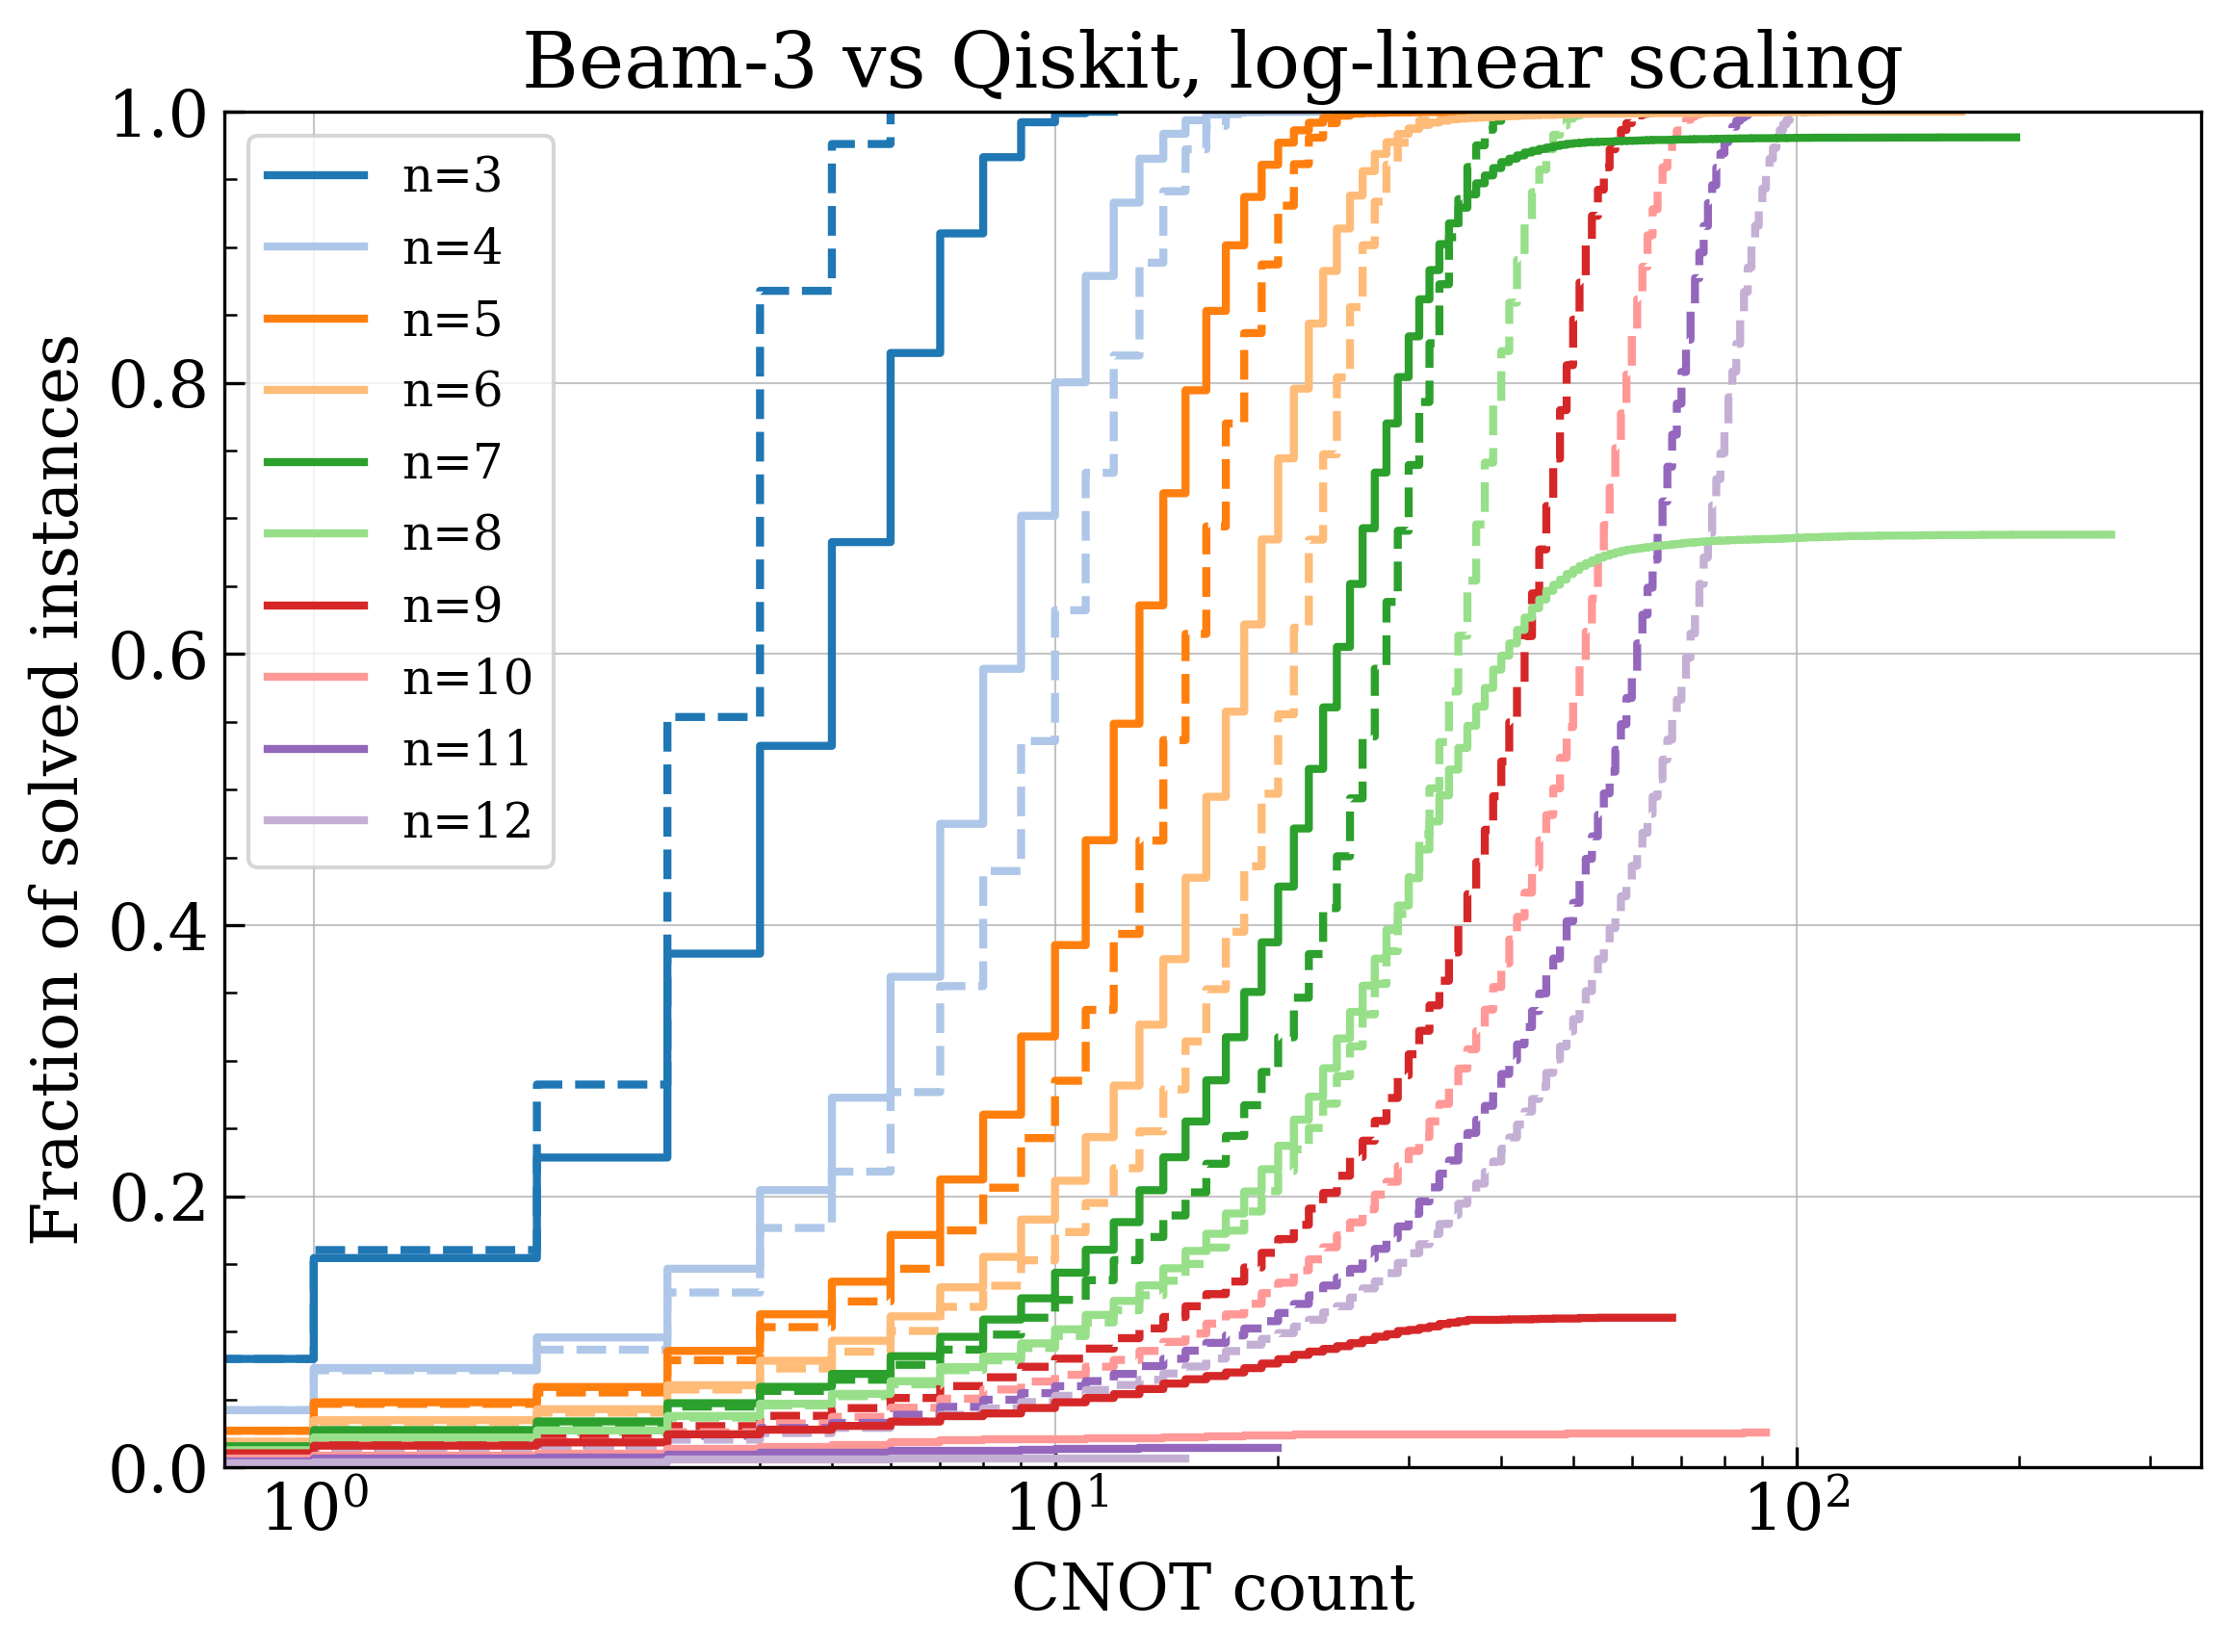

In [16]:
## Beam-search only
fig, ax = plt.subplots(1, 1, figsize=(1 * 8, 1 * 6), dpi=300)

scaling = 'log-linear'
metric = 'CNOTs'
xlabel = 'CNOT count'

for i, num_qubits in enumerate(num_qubit_list):
    eval_dir = 'eval'
    eval_max_iter = 1000
    eval_num_trials = 20000
    with open(
        f"data/" + data_dirs[scaling][num_qubits] + f"/{eval_dir}/steps_until_success_eval_max_iter_{eval_max_iter}_eval_num_trials_{eval_num_trials}_sampling_method_random_walk.pkl", "rb"
    ) as f:
        steps_until_success = pickle.load(f)

    cum_steps_utils_success_qiskit = np.sort(
        [n for n in steps_until_success[f"qiskit"][metric] if n is not None]
    )
    ax.step(
        cum_steps_utils_success_qiskit,
        np.arange(len(cum_steps_utils_success_qiskit))
        / len(steps_until_success["qiskit"][metric]),
        #label=f"n={num_qubits}",
        linewidth=2,
        alpha=1.0,
        linestyle="--",
        color=colors[i % len(colors)],
    )

for i, num_qubits in enumerate(num_qubit_list):
    eval_dir = 'eval_beamsearch'
    
    # use the more intensive evaluation data if available
    if num_qubits < 9:
        eval_max_iter = 1000
        eval_num_trials = 20000
    else:
        eval_max_iter = 200
        eval_num_trials = 5000
    with open(
        f"data/" + data_dirs[scaling][num_qubits] + f"/{eval_dir}/steps_until_success_eval_max_iter_{eval_max_iter}_eval_num_trials_{eval_num_trials}_sampling_method_random_walk.pkl", "rb"
    ) as f:
        steps_until_success = pickle.load(f)

    cum_steps_utils_success_beam = np.sort(
        [n for n in steps_until_success[f"beam-{beam_width}"][metric] if n is not None]
    )
    ax.step(
        cum_steps_utils_success_beam,
        np.arange(len(cum_steps_utils_success_beam))
        / len(steps_until_success["beam-3"][metric]),
        label=f"n={num_qubits}",
        linewidth=2,
        alpha=1.0,
        linestyle="-",
        color=colors[i % len(colors)],
    )

ax.set_xscale("log")
ax.set_xlabel(xlabel)
ax.set_ylabel("Fraction of solved instances")
ax.set_title(f"Beam-3 vs Qiskit, {scaling} scaling")
ax.set_ylim([0, 1])
#ax.set_xlim([1, 100])

ax.legend(ncol=1, fontsize=12)
plt.minorticks_on()
plt.tight_layout()
#plt.savefig(f"{figure_dir}/cumulative_plot.png")
plt.show()

In [17]:
# define the win-rate
def win_rate(delta):
    wins = np.sum(delta > 0)
    ties = np.sum(delta == 0)
    return (wins + 0.5 * ties) / len(delta)

Extract the conditional statistics (conditional here means that the LGF algorithm terminated successfully). Store the data in nested dictionaries with the key structure:

- method (lgf or beam-3)  
    - scaling (linear or log-linear)    
      - num_qubits (3 to 12)      
        - data  

In [18]:
steps_until_success_conditional = {
    "lgf": {scaling: {n: None for n in num_qubit_list} for scaling in scaling_list},
    "beam-3": {scaling: {n: None for n in num_qubit_list} for scaling in scaling_list},
}
metric = "CNOTs"

# loop over the two methods
for method in ["lgf", "beam-3"]:

    if method == "lgf":
        eval_dir = "eval"
    else:
        eval_dir = "eval_beamsearch"

    # loop over scaling
    for scaling in ["linear", "log-linear"]:

        # loop over num_qubits
        for num_qubits in num_qubit_list:
            
            # use the more intensive evaluation data if available
            if method == "lgf":
                eval_max_iter = 1000
                eval_num_trials = 20000
            else:
                if (scaling == 'log-linear' and num_qubits < 9) or (scaling == 'linear' and num_qubits < 7):
                    eval_max_iter = 1000
                    eval_num_trials = 20000
                else:
                    eval_max_iter = 200
                    eval_num_trials = 5000

            # load
            with open(f"data/" + data_dirs[scaling][num_qubits] + f"/{eval_dir}/steps_until_success_eval_max_iter_{eval_max_iter}_eval_num_trials_{eval_num_trials}_sampling_method_random_walk.pkl", "rb") as f:
                steps_until_success = pickle.load(f)

            steps_qiskit = steps_until_success["qiskit"][metric]
            if method == 'lgf':
                steps_guided = steps_until_success["lgf"][metric]
            else:
                steps_guided = steps_until_success["beam-3"][metric]

            # only retain step count for instances where guided method succeeded
            steps_qiskit = np.asarray([step for i_step, step in enumerate(steps_qiskit) if steps_guided[i_step] is not None])
            steps_guided = np.asarray([step for i_step, step in enumerate(steps_guided) if steps_guided[i_step] is not None])

            sample_size = len(steps_guided)

            # build the data dict and store it
            data_dict = {
                "eval_num_trials": eval_num_trials,
                "eval_max_iter": eval_max_iter,
                "steps_qiskit": steps_qiskit,
                "steps_guided": steps_guided,
            }
            steps_until_success_conditional[method][scaling][num_qubits] = data_dict

            # print out statistics
            sample_size_nontrivial = np.sum(steps_qiskit != 0)
            median_num_CNOTs_qiskit = np.median(steps_qiskit)
            max_num_CNOTs_qiskit = np.max(steps_qiskit)
            delta = steps_qiskit - steps_guided
            indices_nontrivial_improvement = (delta > 0)
            fractional_improvement = delta[indices_nontrivial_improvement] / steps_qiskit[indices_nontrivial_improvement]

            out_string = (
                "=" * 50 + "\n"
                f"Results for method={method}, scaling={scaling}, n={num_qubits}\n\n"
                f"eval_num_trials={eval_num_trials}, eval_max_iter={eval_max_iter}\n"
                f"solved instances: {sample_size}\n"
                f"solved instances with CNOT Qiskit count > 0: {sample_size_nontrivial}\n"
                f"percent of solved instances: {100.0 * sample_size/eval_num_trials:.2f}%\n"
                f"percent of instances where guided method beats Qiskit: {100*np.mean(delta > 0):.2f}%\n"
                f"percent of instances where guided method beats or matches Qiskit: {100*np.mean(delta >= 0):.2f}%\n"
                f"fractional CNOT improvement: {100*np.mean(fractional_improvement):.2f}\n%"
                #f"win rate against Qiskit {100*win_rate(delta):.2f}%\n"
            )
            print(out_string)

/home/gavin/.local/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/gavin/.local/lib/python3.10/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Results for method=lgf, scaling=linear, n=3

eval_num_trials=20000, eval_max_iter=1000
solved instances: 20000
solved instances with CNOT Qiskit count > 0: 17565
percent of solved instances: 100.00%
percent of instances where guided method beats Qiskit: 0.00%
percent of instances where guided method beats or matches Qiskit: 47.48%
fractional CNOT improvement: nan
%
Results for method=lgf, scaling=linear, n=4

eval_num_trials=20000, eval_max_iter=1000
solved instances: 20000
solved instances with CNOT Qiskit count > 0: 18320
percent of solved instances: 100.00%
percent of instances where guided method beats Qiskit: 18.71%
percent of instances where guided method beats or matches Qiskit: 57.34%
fractional CNOT improvement: 25.95
%
Results for method=lgf, scaling=linear, n=5

eval_num_trials=20000, eval_max_iter=1000
solved instances: 8664
solved instances with CNOT Qiskit count > 0: 7531
percent of solved instances: 43.32%
percent of instances where guided method beats Qiskit: 24.26%
per